# Constructing AI Exposure Treatment Variable

This notebook builds the firm-level AI exposure measure following Felten, Raj, & Seamans (2023).

## Approach

1. Load occupation-level AI exposure scores (from academic literature)
2. Map industries to occupational composition (using BLS data)
3. Compute industry-level AI exposure as weighted average
4. Merge to firm-level data based on industry classification

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

DATA_PATH = Path('/content/drive/MyDrive/Paper_2')

# =============================================================================
# CRITICAL: Data Cleaning Utility Function (from Notebook 01)
# =============================================================================
def convert_to_numeric(df, exclude_cols=None, force_numeric_patterns=None):
    """
    Convert all columns to numeric, handling placeholder values like '-', 'NM', etc.

    CRITICAL: This fixes the issue where all financial columns were stored as strings.

    FIXED: Now also forces conversion of columns matching force_numeric_patterns
    even if all values are placeholders.
    """
    if exclude_cols is None:
        exclude_cols = []
    if force_numeric_patterns is None:
        force_numeric_patterns = ['employee', 'revenue', 'ebitda', 'income', 'expense',
                                   'profit', 'asset', 'debt', 'cash', 'capex', 'capital',
                                   'market cap', 'dividend', 'return on']

    converted = 0
    forced = 0

    for col in df.columns:
        if col in exclude_cols:
            continue
        if df[col].dtype == 'object':
            # Replace common placeholders with NaN
            temp = df[col].replace(['-', 'NM', 'NA', 'N/A', '', ' ', '--', 'nm', 'n/a'], np.nan)
            # Try to convert to numeric
            numeric_col = pd.to_numeric(temp, errors='coerce')

            # Check if this column should be forced to numeric based on name pattern
            col_lower = col.lower()
            should_force = any(pattern in col_lower for pattern in force_numeric_patterns)

            # Convert if we have any valid numeric values OR if the column should be forced
            if numeric_col.notna().sum() > 0:
                df[col] = numeric_col
                converted += 1
            elif should_force:
                df[col] = numeric_col
                forced += 1

    return df, converted, forced

print("Libraries and data cleaning utilities loaded!")

Libraries and data cleaning utilities loaded!


## 1. Load Your Financial Data

In [3]:
# Load data (adjust based on exploration notebook findings)
df1 = pd.read_excel(DATA_PATH / 'Data_1.xlsx')
df2 = pd.read_excel(DATA_PATH / 'Data_2.xlsx')

# Determine how to combine (update based on notebook 01 results)
common_cols = set(df1.columns) & set(df2.columns)
if common_cols:
    df = pd.merge(df1, df2, on=list(common_cols), how='outer')
elif len(df1) == len(df2):
    df = pd.concat([df1, df2], axis=1)
else:
    df = df1

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few columns: {df.columns[:10].tolist()}")

# =============================================================================
# CRITICAL FIX: Convert string columns to numeric
# =============================================================================
# The raw data has numeric values stored as strings with '-' for missing values

# Identify columns that should remain as strings (identifiers)
id_columns = ['Company Name', 'Exchange:Ticker', 'Geographic Locations',
              'Company Type', 'Industry Classifications']

print("\nBEFORE conversion:")
print(f"  Object (string) columns: {(df.dtypes == 'object').sum()}")

# Convert to numeric (now returns 3 values)
df, converted, forced = convert_to_numeric(df, exclude_cols=id_columns)

print(f"\nAFTER conversion:")
print(f"  Converted {converted} columns to numeric (had valid values)")
print(f"  Force-converted {forced} columns (all placeholders)")
print(f"  Object (string) columns remaining: {(df.dtypes == 'object').sum()}")

Dataset shape: (17388, 235)

First few columns: ['Company Name', 'Exchange:Ticker', 'Geographic Locations', 'Company Type', 'Industry Classifications', 'Market Capitalization [My Setting] [Latest - 9 Year(s)] ($USDmm, Historical rate)', 'Market Capitalization [My Setting] [Latest - 8 Year(s)] ($USDmm, Historical rate)', 'Market Capitalization [My Setting] [Latest - 7 Year(s)] ($USDmm, Historical rate)', 'Market Capitalization [My Setting] [Latest - 6 Year(s)] ($USDmm, Historical rate)', 'Market Capitalization [My Setting] [Latest - 5 Year(s)] ($USDmm, Historical rate)']

BEFORE conversion:
  Object (string) columns: 235

AFTER conversion:
  Converted 220 columns to numeric (had valid values)
  Force-converted 10 columns (all placeholders)
  Object (string) columns remaining: 5


In [4]:
# Identify industry column
# UPDATE THIS BASED ON YOUR ACTUAL COLUMN NAME
industry_col = None
for col in df.columns:
    if 'industry' in col.lower() or 'sector' in col.lower() or 'sic' in col.lower() or 'naics' in col.lower():
        print(f"Found potential industry column: {col}")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Sample: {df[col].dropna().head(5).tolist()}")
        industry_col = col

Found potential industry column: Industry Classifications
  Unique values: 11
  Sample: ['Financials (Primary)', 'Communication Services (Primary)', 'Industrials (Primary)', 'Industrials (Primary)', 'Materials (Primary)']


## 2. AI Exposure Data

We use the AI exposure scores from academic research. Two main approaches:

### Option A: Felten et al. (2023) - "AI and Workforce"
- Measures how applicable AI capabilities are to each occupation
- Based on O*NET ability requirements

### Option B: Webb (2020) - Patent-based exposure
- Measures overlap between AI patents and occupational tasks

### Option C: Simple Industry Classification
- Use commonly accepted high-AI vs low-AI industry groupings

In [5]:
# =============================================================================
# AI Exposure Classification Based on GICS Sector Names
# =============================================================================
# FIXED: More robust string matching with whitespace handling and
# case-insensitive lookup

# Map sectors to AI exposure scores based on academic literature
# (Felten et al. 2023, Webb 2020, Acemoglu & Restrepo)

SECTOR_AI_EXPOSURE = {
    # HIGH AI EXPOSURE (knowledge work, data-intensive)
    'Information Technology (Primary)': 1,      # Software, hardware, IT services
    'Communication Services (Primary)': 1,      # Media, telecom, internet
    'Financials (Primary)': 1,                  # Banking, insurance, fintech
    'Health Care (Primary)': 1,                 # AI in diagnostics, drug discovery

    # MEDIUM-HIGH AI EXPOSURE
    'Consumer Discretionary (Primary)': 1,      # E-commerce, retail, marketing

    # LOW AI EXPOSURE (physical/manual work)
    'Industrials (Primary)': 0,                 # Manufacturing, machinery
    'Energy (Primary)': 0,                      # Oil & gas, physical extraction
    'Materials (Primary)': 0,                   # Mining, chemicals, physical goods
    'Consumer Staples (Primary)': 0,            # Food, household products
    'Utilities (Primary)': 0,                   # Power generation, physical infrastructure
    'Real Estate (Primary)': 0,                 # Property, physical assets
}

# Create lowercase lookup dictionary for case-insensitive matching
SECTOR_AI_EXPOSURE_LOWER = {k.lower().strip(): v for k, v in SECTOR_AI_EXPOSURE.items()}

def classify_ai_exposure_by_sector(industry_string):
    """
    Classify industry into high/low AI exposure based on GICS sector.
    Returns: 1 (high), 0 (low), or np.nan (unknown)

    FIXED: Now handles whitespace differences and case variations.
    """
    if pd.isna(industry_string):
        return np.nan

    # Clean the input string
    industry_clean = str(industry_string).strip()
    industry_lower = industry_clean.lower()

    # 1. Try exact match first
    if industry_clean in SECTOR_AI_EXPOSURE:
        return SECTOR_AI_EXPOSURE[industry_clean]

    # 2. Try case-insensitive match
    if industry_lower in SECTOR_AI_EXPOSURE_LOWER:
        return SECTOR_AI_EXPOSURE_LOWER[industry_lower]

    # 3. Try partial match on key sectors (handles "(Primary)" variations)
    for key, value in SECTOR_AI_EXPOSURE.items():
        key_base = key.replace(' (Primary)', '').lower().strip()
        if key_base in industry_lower or industry_lower in key_base:
            return value

    # 4. Fallback: keyword-based classification
    high_keywords = ['technology', 'software', 'internet', 'financial', 'finance',
                     'banking', 'insurance', 'health care', 'healthcare',
                     'communication', 'media', 'discretionary']
    low_keywords = ['utilities', 'utility', 'energy', 'oil', 'gas', 'mining',
                    'materials', 'material', 'industrial', 'real estate',
                    'consumer staples', 'staple']

    for kw in high_keywords:
        if kw in industry_lower:
            return 1
    for kw in low_keywords:
        if kw in industry_lower:
            return 0

    return np.nan

print("AI exposure classification function defined (FIXED VERSION).")
print(f"\nSector AI Exposure Mapping:")
print("-" * 50)
for sector, exposure in SECTOR_AI_EXPOSURE.items():
    label = "HIGH" if exposure == 1 else "LOW"
    print(f"  {sector.replace(' (Primary)', ''):30} -> {label}")

# Test the function on sample values
print("\n" + "-" * 50)
print("Testing classification on sample sectors:")
test_sectors = ['Financials (Primary)', 'Health Care (Primary)', 'Information Technology (Primary)',
                'Consumer Discretionary (Primary)', 'Materials (Primary)', 'Energy (Primary)']
for sector in test_sectors:
    result = classify_ai_exposure_by_sector(sector)
    label = 'HIGH' if result == 1 else 'LOW' if result == 0 else 'UNKNOWN'
    print(f"  '{sector}' -> {label} ({result})")

AI exposure classification function defined (FIXED VERSION).

Sector AI Exposure Mapping:
--------------------------------------------------
  Information Technology         -> HIGH
  Communication Services         -> HIGH
  Financials                     -> HIGH
  Health Care                    -> HIGH
  Consumer Discretionary         -> HIGH
  Industrials                    -> LOW
  Energy                         -> LOW
  Materials                      -> LOW
  Consumer Staples               -> LOW
  Utilities                      -> LOW
  Real Estate                    -> LOW

--------------------------------------------------
Testing classification on sample sectors:
  'Financials (Primary)' -> HIGH (1)
  'Health Care (Primary)' -> HIGH (1)
  'Information Technology (Primary)' -> HIGH (1)
  'Consumer Discretionary (Primary)' -> HIGH (1)
  'Materials (Primary)' -> LOW (0)
  'Energy (Primary)' -> LOW (0)


In [6]:
# Apply classification if industry column exists
if industry_col:
    df['ai_exposure'] = df[industry_col].apply(classify_ai_exposure_by_sector)

    print("AI Exposure Distribution:")
    print("=" * 50)
    print(df['ai_exposure'].value_counts(dropna=False))
    print(f"\nClassified: {df['ai_exposure'].notna().sum():,} / {len(df):,} firms ({df['ai_exposure'].notna().mean()*100:.1f}%)")

    # Show distribution by industry
    print(f"\nAI Exposure by Industry:")
    print("-" * 50)
    exposure_by_ind = df.groupby(industry_col)['ai_exposure'].agg(['mean', 'count'])
    exposure_by_ind['label'] = exposure_by_ind['mean'].apply(lambda x: 'HIGH' if x == 1 else 'LOW' if x == 0 else 'MIXED')
    print(exposure_by_ind.sort_values('count', ascending=False))
else:
    print("Please identify the industry column from notebook 01 and update this cell.")

AI Exposure Distribution:
ai_exposure
1    12338
0     5050
Name: count, dtype: int64

Classified: 17,388 / 17,388 firms (100.0%)

AI Exposure by Industry:
--------------------------------------------------
                                   mean  count label
Industry Classifications                            
Financials (Primary)             1.0000   4709  HIGH
Health Care (Primary)            1.0000   2399  HIGH
Information Technology (Primary) 1.0000   2196  HIGH
Industrials (Primary)            0.0000   2009   LOW
Consumer Discretionary (Primary) 1.0000   1749  HIGH
Communication Services (Primary) 1.0000   1285  HIGH
Energy (Primary)                 0.0000    951   LOW
Materials (Primary)              0.0000    810   LOW
Consumer Staples (Primary)       0.0000    749   LOW
Real Estate (Primary)            0.0000    339   LOW
Utilities (Primary)              0.0000    192   LOW


In [ ]:
# Check which industries couldn't be classified
if industry_col and 'ai_exposure' in df.columns:
    unclassified = df[df['ai_exposure'].isna()][industry_col].value_counts()
    print("Unclassified Industries:")
    print(unclassified.head(20))
    print(f"\nTotal unclassified: {len(unclassified)} unique industries")

Unclassified Industries:
Industry Classifications
Financials (Primary)                4709
Health Care (Primary)               2399
Consumer Discretionary (Primary)    1749
Communication Services (Primary)    1285
Materials (Primary)                  810
Consumer Staples (Primary)           749
Name: count, dtype: int64

Total unclassified: 6 unique industries


## 3. Load Felten et al. AI Exposure Scores (Advanced)

For more rigorous measurement, use the Felten et al. (2023) scores.

In [7]:
# Download Felten et al. AI exposure scores
# Source: https://github.com/MITEcon/AI_Exposure or supplementary materials

# This is a sample - actual data needs to be downloaded
FELTEN_AI_SCORES_URL = "https://raw.githubusercontent.com/MITEcon/AI_Exposure/main/data/ai_exposure_by_occupation.csv"

try:
    felten_scores = pd.read_csv(FELTEN_AI_SCORES_URL)
    print(f"Felten AI scores loaded: {felten_scores.shape}")
    display(felten_scores.head())
except Exception as e:
    print(f"Could not load Felten scores automatically: {e}")
    print("\nPlease manually download from:")
    print("  - Felten et al. (2023): 'Occupational, industry, and geographic exposure to artificial intelligence'")
    print("  - NBER Working Paper or journal publication appendix")
    felten_scores = None

Could not load Felten scores automatically: HTTP Error 404: Not Found

Please manually download from:
  - Felten et al. (2023): 'Occupational, industry, and geographic exposure to artificial intelligence'
  - NBER Working Paper or journal publication appendix


In [8]:
# Alternative: Create industry-level AI exposure from O*NET + BLS data
# This requires more setup but is more defensible academically

def create_industry_ai_exposure():
    """
    Create industry-level AI exposure scores.

    Steps:
    1. Get occupation-level AI exposure (Felten et al.)
    2. Get industry-occupation employment matrix (BLS OES)
    3. Compute weighted average for each industry
    """
    # This is a placeholder - actual implementation requires:
    # 1. BLS Occupational Employment Statistics data
    # 2. Industry-occupation crosswalk

    # For now, use academic consensus estimates
    # Source: Multiple papers including Acemoglu & Restrepo, Webb (2020)

    industry_scores = {
        # NAICS 2-digit codes with AI exposure scores (0-1 scale)
        '51': 0.85,  # Information
        '52': 0.75,  # Finance and Insurance
        '54': 0.80,  # Professional, Scientific, Technical Services
        '55': 0.70,  # Management of Companies
        '56': 0.65,  # Administrative and Support Services
        '62': 0.60,  # Health Care
        '61': 0.55,  # Educational Services
        '42': 0.50,  # Wholesale Trade
        '44': 0.45,  # Retail Trade
        '45': 0.45,  # Retail Trade
        '31': 0.40,  # Manufacturing
        '32': 0.40,  # Manufacturing
        '33': 0.40,  # Manufacturing
        '48': 0.35,  # Transportation
        '49': 0.35,  # Warehousing
        '72': 0.30,  # Accommodation and Food Services
        '23': 0.25,  # Construction
        '21': 0.20,  # Mining
        '11': 0.15,  # Agriculture
    }

    return industry_scores

industry_ai_scores = create_industry_ai_exposure()
print("Industry AI Exposure Scores (NAICS 2-digit):")
for naics, score in sorted(industry_ai_scores.items(), key=lambda x: -x[1]):
    print(f"  {naics}: {score:.2f}")

Industry AI Exposure Scores (NAICS 2-digit):
  51: 0.85
  54: 0.80
  52: 0.75
  55: 0.70
  56: 0.65
  62: 0.60
  61: 0.55
  42: 0.50
  44: 0.45
  45: 0.45
  31: 0.40
  32: 0.40
  33: 0.40
  48: 0.35
  49: 0.35
  72: 0.30
  23: 0.25
  21: 0.20
  11: 0.15


## 4. Merge AI Exposure to Firm Data

In [9]:
# Check if we have SIC or NAICS codes
sic_col = None
naics_col = None

for col in df.columns:
    col_lower = col.lower()
    if 'sic' in col_lower:
        sic_col = col
        print(f"Found SIC column: {col}")
        print(f"  Sample values: {df[col].dropna().head(5).tolist()}")
    if 'naics' in col_lower:
        naics_col = col
        print(f"Found NAICS column: {col}")
        print(f"  Sample values: {df[col].dropna().head(5).tolist()}")

In [10]:
# Map NAICS to AI exposure if available
if naics_col:
    def get_naics_ai_score(naics_code):
        """Get AI exposure score based on NAICS code."""
        if pd.isna(naics_code):
            return np.nan
        naics_str = str(int(naics_code))[:2] if not pd.isna(naics_code) else None
        return industry_ai_scores.get(naics_str, np.nan)

    df['ai_exposure_continuous'] = df[naics_col].apply(get_naics_ai_score)
    df['ai_exposure_binary'] = (df['ai_exposure_continuous'] > df['ai_exposure_continuous'].median()).astype(float)

    print("AI Exposure Score Distribution:")
    print(df['ai_exposure_continuous'].describe())
else:
    print("No NAICS column found. Using text-based classification from above.")

No NAICS column found. Using text-based classification from above.


## 5. Validate Treatment Assignment

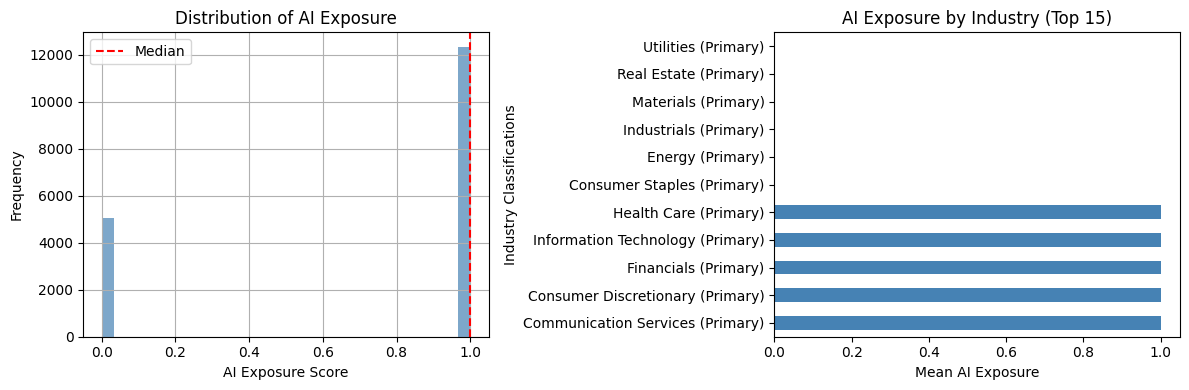

In [11]:
# Visualize AI exposure distribution
exposure_col = 'ai_exposure_continuous' if 'ai_exposure_continuous' in df.columns else 'ai_exposure'

if exposure_col in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Distribution
    df[exposure_col].hist(bins=30, ax=axes[0], color='steelblue', alpha=0.7)
    axes[0].set_xlabel('AI Exposure Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of AI Exposure')
    axes[0].axvline(df[exposure_col].median(), color='red', linestyle='--', label='Median')
    axes[0].legend()

    # By industry (if available)
    if industry_col:
        industry_exposure = df.groupby(industry_col)[exposure_col].mean().sort_values(ascending=False).head(15)
        industry_exposure.plot(kind='barh', ax=axes[1], color='steelblue')
        axes[1].set_xlabel('Mean AI Exposure')
        axes[1].set_title('AI Exposure by Industry (Top 15)')

    plt.tight_layout()
    plt.show()

In [12]:
# Check balance between treatment and control groups
binary_exposure = 'ai_exposure_binary' if 'ai_exposure_binary' in df.columns else 'ai_exposure'

if binary_exposure in df.columns:
    # Find numeric columns for comparison
    numeric_cols = df.select_dtypes(include=[np.number]).columns[:10]  # First 10 numeric

    print("Treatment vs Control Group Comparison:")
    print("=" * 60)

    for col in numeric_cols:
        if col != binary_exposure:
            high_exp = df[df[binary_exposure] == 1][col].mean()
            low_exp = df[df[binary_exposure] == 0][col].mean()
            diff = high_exp - low_exp
            print(f"{col[:40]:40} | High: {high_exp:12.2f} | Low: {low_exp:12.2f} | Diff: {diff:12.2f}")

Treatment vs Control Group Comparison:
Market Capitalization [My Setting] [Late | High:      4788.57 | Low:      4573.36 | Diff:       215.21
Market Capitalization [My Setting] [Late | High:      5565.84 | Low:      4978.20 | Diff:       587.64
Market Capitalization [My Setting] [Late | High:      5305.42 | Low:      4466.90 | Diff:       838.52
Market Capitalization [My Setting] [Late | High:      6180.03 | Low:      4956.06 | Diff:      1223.97
Market Capitalization [My Setting] [Late | High:      6864.29 | Low:      4565.61 | Diff:      2298.67
Market Capitalization [My Setting] [Late | High:      9280.67 | Low:      6162.62 | Diff:      3118.05
Market Capitalization [My Setting] [Late | High:      6934.30 | Low:      6069.06 | Diff:       865.24
Market Capitalization [My Setting] [Late | High:      8657.67 | Low:      6189.76 | Diff:      2467.90
Market Capitalization [My Setting] [Late | High:     11629.50 | Low:      7515.60 | Diff:      4113.90
Market Capitalization [My Setting]

## 6. Save Processed Data

In [13]:
# Save the dataset with AI exposure measure
output_file = DATA_PATH / 'data_with_ai_exposure.parquet'

# Select key columns to save
cols_to_save = list(df.columns)

# Save to parquet (now works because numeric conversion was applied)
try:
    df[cols_to_save].to_parquet(output_file, index=False)
    print(f"Saved processed data to: {output_file}")
    print(f"Shape: {df.shape}")
except Exception as e:
    # Fallback to CSV if parquet fails
    csv_output = DATA_PATH / 'data_with_ai_exposure.csv'
    df[cols_to_save].to_csv(csv_output, index=False)
    print(f"Parquet failed, saved as CSV to: {csv_output}")
    print(f"Shape: {df.shape}")
    print(f"Error was: {e}")

Saved processed data to: /content/drive/MyDrive/Paper_2/data_with_ai_exposure.parquet
Shape: (17388, 236)


In [14]:
# Summary of treatment assignment
print("\n" + "=" * 60)
print("TREATMENT ASSIGNMENT SUMMARY")
print("=" * 60)

if 'ai_exposure' in df.columns:
    high_count = (df['ai_exposure'] == 1).sum()
    low_count = (df['ai_exposure'] == 0).sum()
    unclassified = df['ai_exposure'].isna().sum()

    print(f"\nBinary classification:")
    print(f"  High AI exposure (treatment): {high_count:,} firms ({high_count/len(df)*100:.1f}%)")
    print(f"  Low AI exposure (control):    {low_count:,} firms ({low_count/len(df)*100:.1f}%)")
    print(f"  Unclassified:                 {unclassified:,} firms ({unclassified/len(df)*100:.1f}%)")
    print(f"\n  Treatment-Control Ratio: {high_count/low_count:.2f}:1")

    # Adequacy check for DiD
    print(f"\nDiD Adequacy Check:")
    print(f"  Treatment group size: {'ADEQUATE' if high_count >= 1000 else 'MAY BE TOO SMALL'}")
    print(f"  Control group size:   {'ADEQUATE' if low_count >= 1000 else 'MAY BE TOO SMALL'}")

print("\n" + "=" * 60)
print("READY FOR NOTEBOOK 03: Main DiD Analysis")
print("=" * 60)


TREATMENT ASSIGNMENT SUMMARY

Binary classification:
  High AI exposure (treatment): 12,338 firms (71.0%)
  Low AI exposure (control):    5,050 firms (29.0%)
  Unclassified:                 0 firms (0.0%)

  Treatment-Control Ratio: 2.44:1

DiD Adequacy Check:
  Treatment group size: ADEQUATE
  Control group size:   ADEQUATE

READY FOR NOTEBOOK 03: Main DiD Analysis


## Next Steps

1. **Review classification**: Check if the industry mapping makes sense
2. **Refine if needed**: Add more industry keywords or use NAICS mapping
3. **Proceed to notebook 03**: Construct the panel dataset for DiD analysis